In [1]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '.95', 'grid.color': '.95'}
)
# sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

os.environ['PYTHONHASHSEED'] = str(2)
np.random.seed(2)

In [2]:
df = pd.read_csv('values_office.csv')
df.head()

time  Toffice_reference  humidity  detected_motions  power  \
0  1/4/2015 0:30              19.45      42.0               0.0    0.0   
1  1/4/2015 0:35              19.45      42.0               0.0    0.0   
2  1/4/2015 0:40              19.45      42.0               0.0    0.0   
3  1/4/2015 0:45              19.45      42.0               0.0    0.0   
4  1/4/2015 0:50              19.45      42.0               0.0    0.0   

   office_CO2_concentration  door  label  
0                     390.0   0.0   -1.0  
1                     390.0   0.0   -1.0  
2                     390.0   0.0   -1.0  
3                     390.0   0.0   -1.0  
4                     390.0   0.0   -1.0

In [3]:
df

time  Toffice_reference  humidity  detected_motions  power  \
0         1/4/2015 0:30              19.45      42.0               0.0    0.0   
1         1/4/2015 0:35              19.45      42.0               0.0    0.0   
2         1/4/2015 0:40              19.45      42.0               0.0    0.0   
3         1/4/2015 0:45              19.45      42.0               0.0    0.0   
4         1/4/2015 0:50              19.45      42.0               0.0    0.0   
...                 ...                ...       ...               ...    ...   
103675  12/30/2015 0:05              18.35      33.0               0.0    0.0   
103676  12/30/2015 0:10              18.35      33.0               0.0    0.0   
103677  12/30/2015 0:15              18.35      33.0               0.0    0.0   
103678  12/30/2015 0:20              18.35      33.0               0.0    0.0   
103679  12/30/2015 0:25              18.35      33.0               0.0    0.0   

        office_CO2_concentration  door  label  
0                          390.0   0.0   -1.0  
1                          390.0   0.0   -1.0  
2                          390.0   0.0   -1.0  
3                          390.0   0.0   -1.0  
4                          390.0   0.0   -1.0  
...                          ...   ...    ...  
103675                     430.0   0.0   -1.0  
103676                     430.0   0.0   -1.0  
103677                     430.0   0.0   -1.0  
103678                     430.0   0.0   -1.0  
103679                     430.0   0.0   -1.0  

[103680 rows x 8 columns]

In [4]:
estimation_data = df[df.label == -1]

In [5]:
train_data = df[df.label != -1 ]

In [6]:
import plotly.express as px
fig = px.histogram(train_data, x="label")
fig.show()

In [7]:
train_data

time  Toffice_reference  humidity  detected_motions  power  \
34542    5/4/2015 0:00              20.71      53.0               0.0    0.0   
34543    5/4/2015 0:05              20.71      53.0               0.0    0.0   
34544    5/4/2015 0:10              20.71      53.0               0.0    0.0   
34545    5/4/2015 0:15              20.71      53.0               0.0    0.0   
34546    5/4/2015 0:20              20.71      53.0               0.0    0.0   
...                ...                ...       ...               ...    ...   
39428  5/20/2015 23:10              22.43      32.0               0.0    0.0   
39429  5/20/2015 23:15              22.43      32.0               0.0    0.0   
39430  5/20/2015 23:20              22.43      32.0               0.0    0.0   
39431  5/20/2015 23:25              22.43      32.0               0.0    0.0   
39432  5/20/2015 23:30              22.43      32.0               0.0    0.0   

       office_CO2_concentration  door     label  
34542                     390.0   0.0 -0.813333  
34543                     390.0   0.0  0.000000  
34544                     390.0   0.0  0.000000  
34545                     390.0   0.0  0.000000  
34546                     390.0   0.0  0.000000  
...                         ...   ...       ...  
39428                     500.0   0.0  0.000000  
39429                     500.0   0.0  0.000000  
39430                     500.0   0.0  0.000000  
39431                     500.0   0.0  0.000000  
39432                     500.0   0.0 -0.999997  

[4891 rows x 8 columns]

In [8]:
train_data.time = pd.to_datetime(train_data.time)
estimation_data.time = pd.to_datetime(estimation_data.time)

In [9]:
train_data.set_index('time', inplace=True)
estimation_data.set_index('time', inplace=True)

In [10]:
train_data = train_data.resample('H').mean()
estimation_data = estimation_data.resample('H').mean().pad()

In [11]:
train_data.head()

Toffice_reference   humidity  detected_motions  power  \
time                                                                         
2015-05-04 00:00:00          20.710000  53.000000               0.0    0.0   
2015-05-04 01:00:00          20.710000  53.000000               0.0    0.0   
2015-05-04 02:00:00          20.710000  53.000000               0.0    0.0   
2015-05-04 03:00:00          20.559594  53.218066               0.0    0.0   
2015-05-04 04:00:00          20.498512  53.000000               0.0    0.0   

                     office_CO2_concentration  door     label  
time                                                           
2015-05-04 00:00:00                390.000000   0.0 -0.067778  
2015-05-04 01:00:00                390.000000   0.0  0.000000  
2015-05-04 02:00:00                390.000000   0.0  0.000000  
2015-05-04 03:00:00                409.137222   0.0  0.000000  
2015-05-04 04:00:00                410.000000   0.0  0.000000

In [12]:
import plotly.express as px
fig = px.histogram(train_data, x="label")
fig.show()

In [13]:
# def level(x):
#     res= 0
#     if x < 0.5 :
#         res = 0
#     if 0.5 <= x :
#         res =1
#     if 1.5 <= x:
#         res =2 
# #     if 2.5 <= x:
# #         res =3
# #     if 3.5 <= x:
# # #         res =4
#     return res

In [19]:
train_data.columns = ['Toffice_reference', 'humidity', 'detected_motions', 'power',
       'office_CO2_concentration', 'door', 'occup']

In [20]:
# # train_data['occup'] = train_data.label.apply(lambda x : 0 if x <= 0.5 else 1)
# train_data['occup'] = train_data.label.apply(lambda x : level(x))

In [21]:
train_data.occup.value_counts()

0.000000    292
1.000000      9
2.000000      3
1.250000      2
1.500000      2
           ... 
1.960417      1
0.862444      1
1.942250      1
1.850000      1
2.654917      1
Name: occup, Length: 103, dtype: int64

In [ ]:
# train_data.drop(['label'], axis =1, inplace=True)
# estimation_data.drop(['label'], axis =1, inplace=True)

In [22]:
#seperate features and target
target = "occup"
X = train_data.drop(target, axis =1)
Y = train_data.loc[:,target]

<AxesSubplot:>

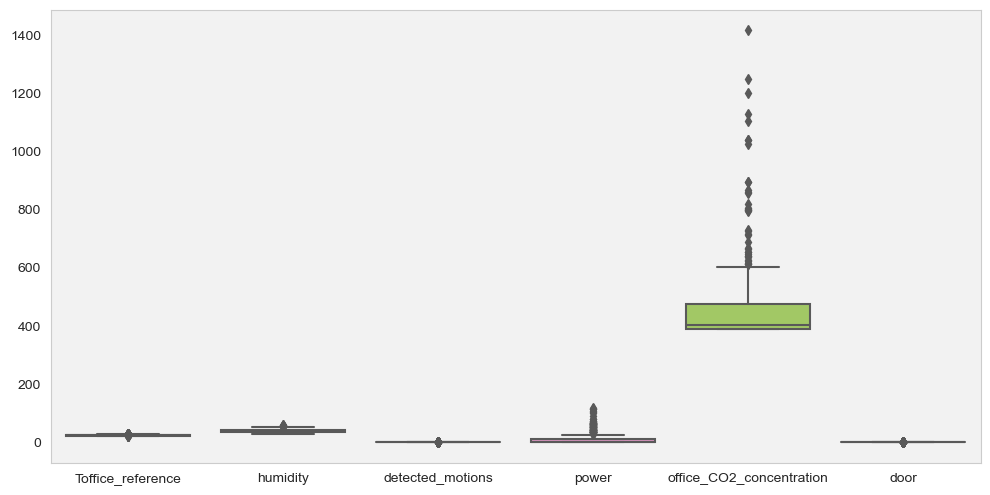

In [23]:
sns.boxplot(data=X, orient="v", palette="Set2")

In [ ]:
# #normalize data
# X = (X - X.mean())/X.std()

In [ ]:
X

<AxesSubplot:>

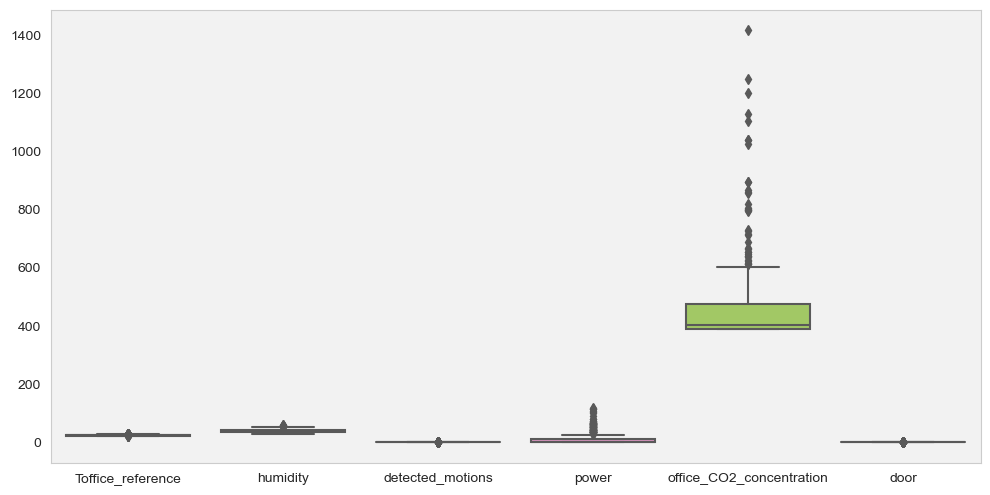

In [24]:
sns.boxplot(data=X, orient="v", palette="Set2")

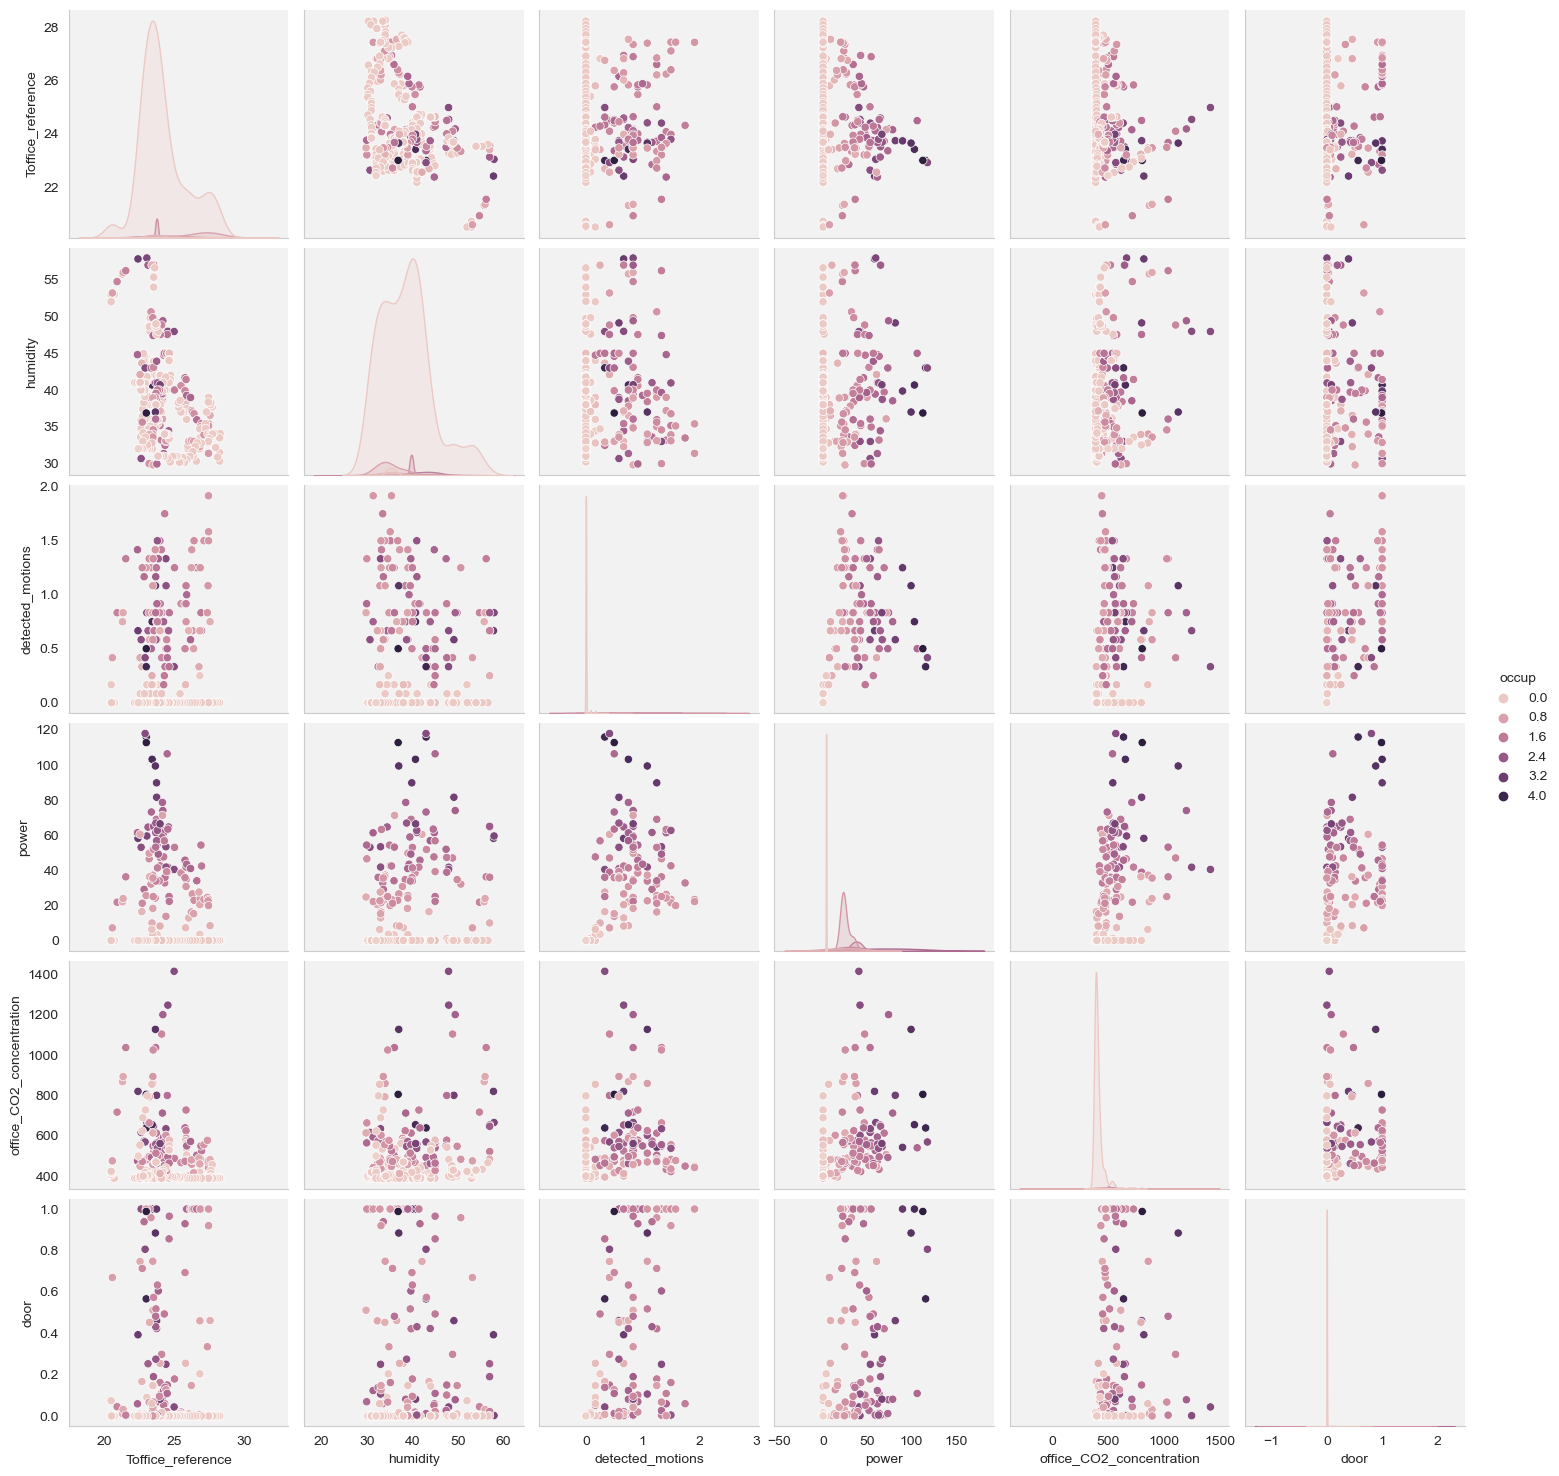

In [25]:
#pairplot
merged = X[:]
merged[target] = Y
sns.pairplot(merged, hue = target)

In [26]:
X.columns

Index(['Toffice_reference', 'humidity', 'detected_motions', 'power',
       'office_CO2_concentration', 'door'],
      dtype='object')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

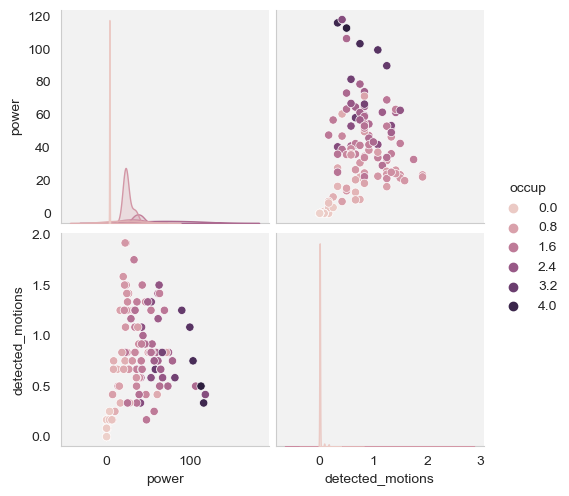

In [27]:
#pairplot
merged = X[:][['power', 'detected_motions']]
merged[target] = Y
sns.pairplot(merged, hue = target)
plt.savefig('img/parplot-m.eps')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [29]:
#Split data into 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state=5)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((326, 6), (82, 6), (326,), (82,))

In [31]:
#Build and train the model
svc_model = SVC()
svc_model.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
#predict the unseen test set and draw the confusion matrix
y_predict = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)

In [ ]:
print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_predict)*100))  
#print('Precision score: %.2f%%' % (precision_score(y_test, y_predict)*100))
#print('Recall score: %.2f%%' % (recall_score(y_test, y_predict)*100))

In [ ]:
sns.heatmap(cm, annot=True, fmt='g').set(title='Confusion matrix')

In [ ]:
# #Plot the confusion matrix and the roc curve
# fig, [ax1, ax2] = plt.subplots(1,2)
# fpr, tpr, _ = roc_curve(y_test,y_predict)
# ax1.plot(fpr, tpr, lw = 2, label = 'AUC: {:.2f}'.format(auc(fpr, tpr)))
# ax1.plot([0, 1], [0, 1],
#             linestyle = '--',
#             color = (0.6, 0.6, 0.6),
#             label = 'Random guessing')
# ax1.plot([0, 0, 1], [0, 1, 1],
#             linestyle = ':',
#             color = 'black', 
#             label = 'Perfect performance')
# ax1.set_xlim([-0.05, 1.05])
# ax1.set_ylim([-0.05, 1.05])
# ax1.set_xlabel('False Positive Rate (FPR)')
# ax1.set_ylabel('True Positive Rate (TPR)')
# ax1.set_title('Receiver Operator Characteristic (ROC) Curve')
# ax1.legend(loc = "lower right")
# fig.tight_layout() 
# sns.heatmap(cm, annot=True, fmt='g', ax=ax2).set(title='Confusion matrix')
# # -----------------------------------------------------
# plt.show()


In [32]:
### Improoving the model
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 

In [33]:
#improoving the model using grid search to find the best parameters
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)

In [34]:
%%time
grid.fit(X_train,y_train)

ValueError: Unknown label type: 'continuous'

In [35]:
#Predixt the classes of the test set
grid_predictions = grid.predict(X_test)

AttributeError: 'SVC' object has no attribute 'shape_fit_'

In [36]:
cm = confusion_matrix(y_test, grid_predictions)

NameError: name 'grid_predictions' is not defined

In [37]:
print('Accuracy score: %.2f%%' %(accuracy_score(y_test, grid_predictions)*100))  
# print('Precision score: %.2f%%' % (precision_score(y_test, grid_predictions)*100))
# print('Recall score: %.2f%%' % (recall_score(y_test, grid_predictions)*100))

NameError: name 'grid_predictions' is not defined

In [38]:
sns.heatmap(cm, annot=True, fmt='g').set(title='Confusion matrix')

NameError: name 'cm' is not defined

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, grid_predictions))

In [ ]:
### Known classification models:

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

def run_classifier(clf, param_grid, title, X_train, X_test):
    # -----------------------------------------------------
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            iid = False,
                            scoring= 'accuracy',
                            verbose=1,
                            n_jobs=-1)
    # -----------------------------------------------------
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    # -----------------------------------------------------
#     print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
#     print('Precision score: %.2f%%' % (precision_score(y_test, y_pred)*100))
#     print('Recall score: %.2f%%' % (recall_score(y_test, y_pred)*100))
#     MSE=mean_squared_error(y_test, y_pred)
#     print("MSE", MSE)
    print(classification_report(y_test, y_pred))
    # ----------------------------------------------------- 
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(21, 7))
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    fig.tight_layout()
    # -----------------------------------------------------
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax2.plot(fpr, tpr, lw = 2, label = 'AUC: {:.2f}'.format(auc(fpr, tpr)))
    ax2.plot([0, 1], [0, 1],
             linestyle = '--',
             color = (0.6, 0.6, 0.6),
             label = 'Random guessing')
    ax2.plot([0, 0, 1], [0, 1, 1],
             linestyle = ':',
             color = 'black', 
             label = 'Perfect performance')
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operator Characteristic (ROC) Curve')
    ax2.legend(loc = "lower right")
    fig.tight_layout()      
    # -----------------------------------------------------
    plt.show()

#### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

param_grid = {'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [ ]:
run_classifier(lr, param_grid, 'Logistic Regression', X_train, X_test)

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(1, 20, 2),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'max_features': ['auto', 'sqrt', 'log2', None]}

In [ ]:
run_classifier(dtree, param_grid, "Decision Tree", X_train, X_test)

#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {'n_estimators': [100, 200],
              'max_depth': [10, 20, 100, None],
              'max_features': ['auto', 'sqrt', None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

In [ ]:
run_classifier(rf, param_grid, 'Random Forest', X_train, X_test)


### Final 


In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {'n_estimators': [100, 200],
              'max_depth': [10, 20, 100, None],
              'max_features': ['auto', 'sqrt', None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

In [40]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

def run_classifier_2(clf, param_grid, title, X_train, X_test):
    # -----------------------------------------------------
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            iid = False,
                            scoring= 'accuracy',
                            verbose=1,
                            n_jobs=-1)
    # -----------------------------------------------------
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    # -----------------------------------------------------
    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
#     print('Precision score: %.2f%%' % (precision_score(y_test, y_pred)*100))
#     print('Recall score: %.2f%%' % (recall_score(y_test, y_pred)*100))
    # ----------------------------------------------------- 
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(21, 7))
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    fig.tight_layout()
    # -----------------------------------------------------
#     # Plot ROC curve
#     fpr, tpr, _ = roc_curve(y_test, y_prob)
#     ax2.plot(fpr, tpr, lw = 2, label = 'AUC: {:.2f}'.format(auc(fpr, tpr)))
#     ax2.plot([0, 1], [0, 1],
#              linestyle = '--',
#              color = (0.6, 0.6, 0.6),
#              label = 'Random guessing')
#     ax2.plot([0, 0, 1], [0, 1, 1],
#              linestyle = ':',
#              color = 'black', 
#              label = 'Perfect performance')
#     ax2.set_xlim([-0.05, 1.05])
#     ax2.set_ylim([-0.05, 1.05])
#     ax2.set_xlabel('False Positive Rate (FPR)')
#     ax2.set_ylabel('True Positive Rate (TPR)')
#     ax2.set_title('Receiver Operator Characteristic (ROC) Curve')
#     ax2.legend(loc = "lower right")
    fig.tight_layout()      
    # -----------------------------------------------------
    plt.show()
    return gs

In [41]:
rf = run_classifier_2(rf, param_grid, 'Random Forest', X_train, X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
predict = rf.best_estimator_.predict(estimation_data)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(final_test, predict))

In [ ]:
estimation_data['occup'] = predict
# estimation_data['time'] = estim_time

In [ ]:
estimation_data.occup.value_counts()

In [ ]:
train_data

In [ ]:
estimation_data

In [ ]:
frames = [train_data, estimation_data]

final_df =  pd.concat(frames)

In [ ]:
final_df

In [ ]:
final_df.occup.value_counts()

In [ ]:
import plotly.express as px
fig = px.histogram(final_df, x="occup")
fig.show()

In [ ]:
# final_df.to_csv('ob-occupancy-multi.csv')

In [ ]:
final_df